In [8]:
import pandas as pd
import wikipediaapi
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
import nltk

ModuleNotFoundError: No module named 'nltk'

## DATA COLLECTION ##########################################################################

In [17]:
def collectBiographiesFromCategories(all_categories, categorymembers, category, data, number_people, level=0, max_level=1): 
    """
    Recursively collects biographical texts and fact graphs for each person in specified Wikipedia category members up to a given recursion level.

    Parameters:
        categorymembers (dict): A dictionary of category member pages from the WikipediaAPI.
        category (str): The name of the category being processed.
        data (list): A list to store biographical text and associated metadata.
        number_people (int): Counter for the number of biographies collected.
        level (int): Current level of recursion through category members.
        max_level (int): Maximum depth of recursion allowed.

    Returns:
        int: Updated count of processed biographies.
    """
    for page in categorymembers.values():
        if page.ns == 0 and 'List' not in page.title and number_people < 130: #limit the number of people for each category to 130 (or more for clustering)

            #some wikipedia page cannot be found in dbpedia, we ignore them
            try: 

                #knowledge graph of facts
                kg_graph = fetchDbpediaFacts(page.pageid, page.title)
                # Save the graph of facts to a JSON file
                #with open('knowledge_graph.json', 'a') as json_file:
                #    json.dump(kg_graph, json_file, indent=4)
                
                all_categories[category].append(kg_graph)
                print(f"{category} {page.title} processed")


                text = page.text
                data.append({'text': text, 'category': category, 'person': (page.title).replace(' ', '')})
                #creation of txt file for the biography
                f = open(f"Biographies_{category}/{(page.title).replace(' ', '')}_{category}.txt", "w", encoding='utf-8')
                f.write(text)
                f.close()

                #keep track of people processed
                number_people += 1  

            except Exception as err:
                print(f"Unexpected {err=}, {type(err)=}, could not process {page.title}")
                continue

            
        if page.ns == wikipediaapi.Namespace.CATEGORY and level < max_level and number_people < 130: #change to 130
            # Recursively call the function to process pages in the subcategory 
            number_people, all_categories = collectBiographiesFromCategories(all_categories, page.categorymembers, category, data, number_people, level=level + 1, max_level=max_level)
    # return updated count of processed people
    return number_people, all_categories

In [18]:
import os
import shutil
import pandas as pd
import wikipediaapi

def createBiographyDataFrames():
    """
    Collects biographical data from Wikipedia categories 'Sculptors' and 'Journalists', 
    creates directories for storing these biographies, and formats the collected data into a pandas DataFrame.

    Returns:
        DataFrame: A pandas DataFrame containing the text and category of each biography collected.
    """
    
    
    wiki = wikipediaapi.Wikipedia('Mozilla/5.0', 'en')

    data = []
    all_categories= {}
    all_categories["Journalists"] = []
    all_categories["Sculptors"] = []
    
    if os.path.exists('Biographies'):
        shutil.rmtree('Biographies')
    
    os.mkdir('Biographies')
    os.chdir('Biographies')
        
    sculptors = wiki.page("Category:Sculptors")
    if not os.path.exists('Biographies_Sculptors'):
        os.mkdir('Biographies_Sculptors') #creates a directory to store all sculptors' biographies
    _, all_categories = collectBiographiesFromCategories(all_categories, sculptors.categorymembers, "Sculptors", data, 0)
    
    journalists = wiki.page("Category:Journalists")
    if not os.path.exists('Biographies_Journalists'):
        os.mkdir('Biographies_Journalists') #creates a directory to store all journalists' biographies
    _, all_categories = collectBiographiesFromCategories(all_categories, journalists.categorymembers, "Journalists", data, 0)

    
    with open('knowledge_graph.json', 'w') as json_file:
            json.dump(all_categories, json_file, indent=4)
            
    df = pd.DataFrame(data)
    return df



In [19]:
def fetchDbpediaFacts(wiki_id, page_title):
    """
    Fetches RDF triples (facts) about a specific Wikipedia page from DBpedia using the page's ID.

    Parameters:
        wiki_id (int): The Wikipedia page ID used to fetch the corresponding DBpedia page.
        page_title (str): Title of the Wikipedia page.

    Returns:
        dict: A dictionary containing RDF triples with DBpedia facts about the page, its title and other metadata.
    """

    #initialize the SPARQL wrapper
    sparql = SPARQLWrapper("http://dbpedia.org/sparql/")

    #first query to retrieve the dbpedia page of the person from the wikipedia page id
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            SELECT *
            WHERE {{
                    ?person dbo:wikiPageID {wiki_id} .
            }}
    """)
    sparql.setReturnFormat(JSON)
    result_link = sparql.query().convert()

    person_wikidata_page = result_link["results"]["bindings"][0]["person"]["value"] #the first value is most likely what we are looking for
    
    #second query to fetch all information as RDF triples
    sparql.setQuery(f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX dbr: <http://dbpedia.org/resource/>
            PREFIX dbp: <http://dbpedia.org/property/>

            DESCRIBE <{person_wikidata_page}>
    """)
    sparql.setReturnFormat(JSON)
    results_facts = sparql.query().convert()
    results_facts['results']['bindings'] = (results_facts['results']['bindings'][:100]) #first 100 facts
    results_facts['head']['person'] = page_title.replace(" ", "")
    
    return(results_facts)

## DATA ANALYSIS ############################################################################

In [9]:
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk.stem.porter import PorterStemmer
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np

# Load Spacy English Model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Etudiant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Segmentation in sentences and tokens and vocabulary

def sentence_segmentation(spacy_text):
    list_of_sentences = []
    for s in spacy_text.sents:
        list_of_sentences.append(s)
    return list_of_sentences

def tokens_segmentation(spacy_text):
    list_of_tokens = []
    for tok in spacy_text:
        list_of_tokens.append(str(tok))
    return list_of_tokens


def lowercase_and_punctuation_remover(spacy_list):
    translator = str.maketrans('', '', string.punctuation) #with string.punctuation being the list of punctuation signs
    return [tok.translate(translator) for tok in [str(tok).lower() for tok in spacy_list]]


def remove_stopwords(spacy_list):
    #print(stopwords.words('english')[:100])
    stopwords_list = stopwords.words('english')
    spacy_list_clean = []
    for token in spacy_list:
        if token not in stopwords_list :
            spacy_list_clean.append(token)
    return spacy_list_clean

def remove_empty_spaces(token_list):
    # Strip each token in the list and remove it if it's empty after stripping
    return [token.strip() for token in token_list if token.strip()]

def stemming(tokens_list):
    # Create a stemmer instance
    porter = PorterStemmer()
    # Apply the stemmer and collect the stems
    porterlemmas = []
    for word in tokens_list:
        porterlemmas.append(porter.stem(word))
    return porterlemmas

def text_data_tok_sent(df):
    #sentences_journalists = []
    #sentences_sculptors = []
    #tokens_journalists = []
    #tokens_sculptors =[]
    #for index, row in df.iterrows():
    #    if(row['category'] == 'Journalists'):
    #        sentences_journalists.extend(sentence_segmentation(nlp(row['text'])))
    #    elif(row['category'] == 'Sculptors'):
    #        sentences_sculptors.extend(sentence_segmentation(nlp(row['text'])))
    
    df['sentences'] = df['text'].apply(lambda x: lowercase_and_punctuation_remover(sentence_segmentation(nlp(x))))
    #sentences_journalists_clean = lowercase_and_punctuation_remover(sentences_journalists)
    #sentences_sculptors_clean = lowercase_and_punctuation_remover(sentences_sculptors)
                                         
    df['tokens'] = df['sentences'].apply(lambda x: stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(x)))))))
    
    #tokens_journalists = stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(sentences_journalists_clean))))))
    #tokens_sculptors = stemming(remove_empty_spaces(remove_stopwords(tokens_segmentation(nlp(' '.join(sentences_sculptors_clean))))))
                                         
    return df #(sentences_journalists_clean, sentences_sculptors_clean, tokens_journalists, tokens_sculptors)

def frequency_and_wordcloud(df):
    categories = df['category'].unique()
    results = {}
    
    for category in categories:
        print(f"50 most frequent words and wordcloud for {category}:")
        tokens_list = [item for sublist in df[df['category'] == category]['tokens'] for item in sublist]
        frequency_dist=nltk.FreqDist(tokens_list)
        frequency_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud = WordCloud().generate(" ".join(tokens_list))
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
    
def data_analysis(df): 
    df = text_data_tok_sent(df)
    frequency_and_wordcloud(df)
    return df
   

In [11]:
import seaborn as sns

def sentences(df):
    
    # Sentence segmentation and count
    df['sentence_count'] = df['sentences'].apply(lambda x: len(x))

    # min, max, and mean sentence counts by category
    stats_df = df.groupby('category')['sentence_count'].agg(['min', 'max', 'mean'])

    # print statistics
    print(stats_df)
    
    # visualization
    categories = df['category'].unique()
    fig, ax = plt.subplots(1, len(categories)+1, figsize=(12, 6))
    counter = 0 #to keep track of the number of a categorie for subplot index
    for category in categories:
        print(df[df["category"] == category])
        sns.histplot(df[df["category"] == category], x = 'sentence_count', ax=ax[counter])

        # set titles for each subplot for clarity
        ax[counter].set_title(f'Sentences length frequency for {category}')
        ax[counter].axvline(stats_df.loc[category, 'mean'], color='r', linestyle='--', linewidth=2, label=f'Mean: {stats_df.loc[category, "mean"]:.2f}')
        counter += 1
    
    sns.boxplot(data=df, x='category', y='sentence_count', ax=ax[counter])
    ax[counter].set_title('Boxplot')
    plt.show()
    

In [12]:
#bigrams

from nltk import bigrams
from nltk.tokenize import word_tokenize

def generate_bigrams(sentences_list):
        all_bigrams = []
        for sent in sentences_list:
            # bigrams from the list of sentences
            tokens = word_tokenize(sent)
            all_bigrams.append(list(bigrams(tokens))) #list of list of bigrams (one per sentence)
        return all_bigrams


def get_bigrams_list(df):
    df['bigrams'] = df['sentences'].apply(generate_bigrams)
    return df
    
def total_bigram_occ(df):
    pers_bigrams = {}
    sent_bigrams = {}
    all_bigrams = {}
    
    categories = df['category'].unique()
    for category in categories:
        pers_bigrams[category] = [x for x in df[df["category"] == category]['bigrams']]
        sent_bigrams[category] = sum(pers_bigrams[category], [])
        all_bigrams[category] = sum(sent_bigrams[category], [])
        print(f"For the category {category}:")
        print(f"  there are {len(all_bigrams[category])} bigrams in total and {len(set(all_bigrams[category]))} unique bigrams")
        print(f"  the minimum number of bigrams in a sentence is {min([len(s) for s in sent_bigrams[category]])}")
        print(f"  the maximum number of bigrams in a sentence is {max([len(s) for s in sent_bigrams[category]])}")
        print(f"  the average number of bigrams in a sentence is {sum([len(s) for s in sent_bigrams[category]])/len(sent_bigrams[category])}")


### Graphs

In [13]:
import re

def retrieve_json(path):
    json_string = open(path)
    
    graph = json.load(json_string)
    return graph

def extract_after_last_slash(text): 
    # for facts, regex to find the part after the last slash (to keep only the fact and not the url)
    match = re.search(r'[^/]+$', text)
    if match:
        return match.group(0)
    return None

def most_freq_properties_and_cloud(json_str):
    properties_per_category = {}
    properties_per_category_clean = {}

    for category, items in json_str.items():
        properties_per_category[category] = []
        properties_per_category_clean[category] = []

        for item in items:
            # extract all 'p' values from the bindings
            bindings = item['results']['bindings']
            for binding in bindings:
                property_value = binding['p']['value']
                #append property
                properties_per_category[category].append(property_value)
                properties_per_category_clean[category] = [extract_after_last_slash(prop) for prop in properties_per_category[category]]

        print(f"50 most frequent properties and wordcloud of properties for {category}:")
        frequency_dist_dist=nltk.FreqDist(properties_per_category_clean[category])
        frequency_dist_dist.plot(50)
        #Create and generate a word cloud image:
        wordcloud_prop = WordCloud().generate(" ".join(properties_per_category_clean[category]))
        # Display the generated image:
        plt.imshow(wordcloud_prop, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
    #print(properties_per_category['Journalists'])

    


## CLUSTERING ###############################################################################

In [3]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.datasets import load_files
import numpy as np

In [4]:
# load the files and extract the text and category in a dataframe
DATA_DIR = "Biographies/"
data_cluster = load_files(DATA_DIR, encoding='utf-8', decode_error="replace")
df_cluster = pd.DataFrame(
    {'text': data_cluster['data'], 
    'category': data_cluster['target']})
df_cluster

,text,category
0,Pavlos Prosalentis (Greek: Παύλος Προσαλέντης;...,1
1,Scott Robinson is a fictional character from t...,0
2,Ricardo Breceda is an artist most well known f...,1
3,"Luis Aranberri (born 1945 in Eibar), better kn...",0
4,Gerhard Henning (27 May 1880 – 16 September 19...,1
...,...,...
255,"Kayode Akintemi (born June 26, 1965) is a Nige...",0
256,"José Belloni (September 12, 1882 – November 2...",1
257,"Thomas Henry Shadwell Clerke, KH (1792–1849), ...",0
258,Hopewell Rugoho-Chin'ono is a Zimbabwean journ...,0


In [5]:
df_cluster.shape

(260, 2)

In [6]:
print(df_cluster.groupby('category').size())

category
0    130
1    130
dtype: int64


In [7]:
df_cluster = shuffle(df_cluster)
df_cluster.head(20)

,text,category
44,"Arturo Ambrogi (1874 – 1936 in San Salvador, E...",0
228,"Carlos Medina is a Venezuelan-born (1953, Barq...",1
169,"Sunday Jack Akpan (born Ikot Ide Etukudo, 1940...",1
256,"José Belloni (September 12, 1882 – November 2...",1
189,Sarah Jane Smith is a fictional character play...,0
55,José Simões de Almeida (sobrinho) (17 June 188...,1
137,Kevin Atherton (born 1950) is an International...,1
134,"Edmundo Prati (17 April 1889, in Paysandú – 24...",1
108,Kudjoe Affutu (born 1985) is a Ghanaian artist...,1
88,Chen Chung-hsin (Chinese: 陳忠信; Pe̍h-ōe-jī: Tân...,0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_cluster['text'], df_cluster['category'], test_size=0.2, random_state=42)

In [9]:
# Using TFIDF vectorizer to convert convert words to Vector Space
# max_features = 800 --> best metrics results
tfidf_vectorizer = TfidfVectorizer(max_features=800, 
                                       use_idf=True,
                                       stop_words='english')
                                       #ngram_range=(1, 2))
                                       #tokenizer=nltk.word_tokenize)
                                      

# Fit the vectorizer to text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)




In [10]:
features = tfidf_vectorizer.get_feature_names_out()
print(features)


['000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1945'
 '1950' '1952' '1953' '1954' '1959' '1961' '1964' '1965' '1966' '1967'
 '1968' '1969' '1970' '1971' '1972' '1973' '1974' '1976' '1977' '1978'
 '1979' '1980' '1983' '1984' '1985' '1986' '1987' '1988' '1989' '1990'
 '1991' '1992' '1993' '1994' '1995' '1996' '1997' '1998' '1999' '20'
 '2000' '2001' '2002' '2003' '2004' '2005' '2006' '2007' '2008' '2009'
 '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020' '2021' '2022' '2023' '21' '22' '23' '24' '25' '26' '27' '28' '30'
 '31' '978' 'able' 'academy' 'according' 'active' 'activities'
 'adaptation' 'added' 'addition' 'aden' 'africa' 'african' 'age' 'agent'
 'agustín' 'aires' 'ajl' 'akpan' 'al' 'alejandro' 'alongside' 'alpuy'
 'america' 'american' 'anatsui' 'andrew' 'angeles' 'announced' 'anthony'
 'anti' 'appeared' 'appears' 'appointed' 'april' 'archived' 'arden'
 'argentina' 'arkady' 'armenian' 'army' 'art' 'arte' 'artes' 'article'
 'articles' 'a

In [11]:

km = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, verbose=0, random_state=42)
km.fit(X_train_tfidf)

# Get cluster assignments for the training data

clusters_train = km.labels_
print("Training data cluster assignments:", clusters_train)

# Apply the model to the test data to get cluster assignments

clusters_test = km.predict(X_test_tfidf)
print("Test data cluster assignments:", X_test_tfidf)



Training data cluster assignments: [1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0
 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1
 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0
 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0]
Test data cluster assignments:   (0, 5)	0.026626298316086983
  (0, 9)	0.05269397238067158
  (0, 14)	0.030419935841976505
  (0, 25)	0.05844778681389555
  (0, 27)	0.0300040335332243
  (0, 28)	0.06083987168395301
  (0, 29)	0.11842333862849626
  (0, 32)	0.06083987168395301
  (0, 34)	0.06083987168395301
  (0, 35)	0.0600080670664486
  (0, 36)	0.030855189266965212
  (0, 38)	0.05771386832751992
  (0, 39)	0.027835237047251365
  (0, 45)	0.08074261799163256
  (0, 48)	0.14081780303526
  (0, 56)	0.05162439426246909
  (0, 60)	0.09930566643671179
  (0

In [12]:
print("Top terms per cluster:")
true_k = np.unique(km.labels_).shape[0]
print("True number of clusters: ", true_k)

order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# for each cluster
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    # print tokens of clusters centroids (TF-IDF decreasing values)
    for ind in order_centroids[i, :10]:  # Adjust the number here to display more or fewer terms
        print(' %s' % features[ind], end='')
    print('\n')


Top terms per cluster:
True number of clusters:  2
Cluster 0: art sculpture sculptor museum work works arts gallery new exhibition

Cluster 1: editor journalist news soviet newspaper el armenian dominican russian la



In [13]:
from sklearn import metrics

# Évaluation avec les données d'entraînement
print("Evaluation for tain data")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, clusters_train))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, clusters_train))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, clusters_train))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_train, clusters_train))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_tfidf, clusters_train, sample_size=100))

# Évaluation avec les données de test
print("\nEvaluation for test data:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, clusters_test))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, clusters_test))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, clusters_test))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_test, clusters_test))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_tfidf, clusters_test, sample_size=100))


Evaluation for tain data
Homogeneity: 0.765
Completeness: 0.770
V-measure: 0.768
Adjusted Rand-Index: 0.816
Silhouette Coefficient: 0.020

Evaluation for test data:
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.032


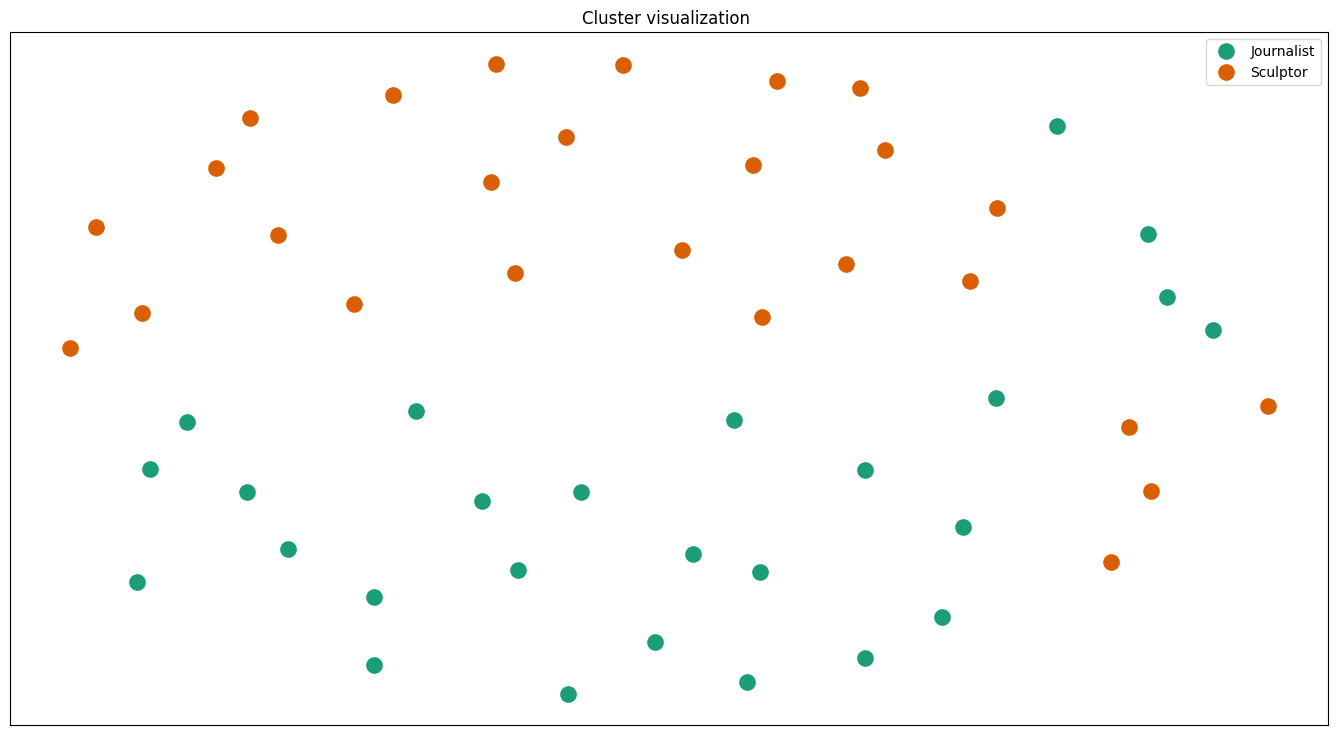

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

#dist_train = 1 - cosine_similarity(X_train_tfidf)
dist_test = 1 - cosine_similarity(X_test_tfidf)

# Use multidimensional scaling to convert the dist matrix into a 2-dimensional array
MDS()

# n_components=2 to plot results in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
#pos_train = mds.fit_transform(dist_train)
pos_test = mds.fit_transform(dist_test)
#xs_train, ys_train = pos_train[:, 0], pos_train[:, 1]
xs_test, ys_test = pos_test[:, 0], pos_test[:, 1]

#set up colors per clusters
cluster_colors = {0: '#1b9e77', 1: '#d95f02'}

#set up cluster names
#cluster_names = {0: 'Other', 1: 'Chemistry', 2: 'Physics'}
cluster_names = {0: 'Journalist', 1: 'Sculptor'}

#create data frame that has the result of the MDS plus the cluster numbers and titles
#df_train = pd.DataFrame(dict(x=xs_train, y=ys_train, label=km.labels_))
df_test = pd.DataFrame(dict(x=xs_test, y=ys_test, label=clusters_test))

#group by cluster
groups = df_test.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9))
ax.margins(0.05)

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_names[name],
            color=cluster_colors[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',
        which='both',
        left=False,
        top=False,
        labelleft=False)

ax.legend(numpoints=1)
plt.title('Cluster visualization ')
plt.show()

## MAIN #####################################################################################

In [15]:
def main():
    df = createBiographyDataFrames()
    df
    #df = data_analysis(df)
    #sentences(df)
    #df = get_bigrams_list(df)
    #total_bigram_occ(df)
    #most_freq_properties_and_cloud(retrieve_json('knowledge_graph.json'))


In [20]:
if __name__=='__main__':
    main()

Unexpected err=IndexError('list index out of range'), type(err)=<class 'IndexError'>, could not process Margaret Trowell


c:\Users\Etudiant\AppData\Local\Programs\Python\Python311\Lib\site-packages\SPARQLWrapper\Wrapper.py:794: RuntimeWarning: Sending Accept header '*/*' because unexpected returned format 'json' in a 'DESCRIBE' SPARQL query form
  warnings.warn(


Sculptors Pavlos Prosalentis processed
Sculptors George Lilanga processed
Sculptors Eric Gill works at the Midland Hotel, Morecambe processed
Sculptors New British Sculpture processed
Sculptors New Sculpture processed
Sculptors Orestes Acquarone processed
Sculptors Georges Adéagbo processed
Sculptors Kudjoe Affutu processed
Sculptors Julio Aguilera processed
Sculptors Adebisi Akanji processed
Sculptors Kwame Akoto-Bamfo processed
Sculptors Sunday Jack Akpan processed
Sculptors Enrique Alférez processed
Sculptors José Simões de Almeida processed
Sculptors Julio Alpuy processed
Sculptors Maximiano Alves processed
Sculptors Eric Adjetey Anang processed
Sculptors El Anatsui processed
Sculptors Mark Antokolsky processed
Sculptors Massoud Arabshahi processed
Sculptors Carmelo Arden Quin processed
Sculptors Pablo Atchugarry processed
Sculptors Kevin Atherton processed
Sculptors Armando de Basto processed
Sculptors Alberto Bautista Gómez processed
Sculptors José Belloni processed
Sculptors Ste